<a href="https://colab.research.google.com/github/nhjung-phd/TimeSeriesAnalysis/blob/main/R/02_MA_forecasting_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARIMA vs SMA — Full Series / Fixed-Origin / Rolling / (SMA Dynamic) Comparison (R)

이 노트북은 TSLA 가격 데이터를 사용해 **ARIMA(0,1,q)**와 **SMA(단순이동평균)**를 비교합니다.

포함된 전략:
- **Full series (ARIMA)**: 전체 구간으로 한 번 적합 → 미래 *h-step* 예측
- **Fixed-origin / Static (ARIMA)**: 학습 80%에서 적합 → 테스트 전 구간 **동적 예측**(실제값 미사용)
- **SMA Dynamic (no actuals)**: 테스트에서 **실제값을 쓰지 않고** 예측만 이어붙임
- **SMA 1-step Rolling**: 매 시점 직전 **p개 실제값**으로 1-step 예측(워크-포워드)

> 참고: SMA는 **값의 평균을 내는 평활**이고, ARIMA의 MA(q)는 **오차 구조를 모형화**하는 확률모형이므로 개념적으로 다릅니다.

In [1]:
## 패키지 설치/로드 -------------------------------------------------------
if (!requireNamespace("pacman", quietly = TRUE)) install.packages("pacman")
pacman::p_load(quantmod, forecast, ggplot2, dplyr, tibble, lubridate, zoo, scales)

theme_set(theme_minimal(base_size = 12))

## 1) 데이터 로드 (Yahoo Finance — TSLA, 2022-01-01 ~ 2024-01-01)

In [2]:
symbol     <- "TSLA"
start_date <- as.Date("2022-01-01")
end_date   <- as.Date("2024-01-01")

xt <- suppressWarnings(quantmod::getSymbols(symbol, src = "yahoo", from = start_date, to = end_date, auto.assign = FALSE))
df <- tibble::tibble(
  Date  = as.Date(index(xt)),
  Close = as.numeric(Cl(xt))
) %>% tidyr::drop_na()

n <- nrow(df)
train_size <- as.integer(n * 0.8)
df_train <- df %>% slice(1:train_size)
df_test  <- df %>% slice((train_size+1):n)

y        <- df$Close
y_train  <- df_train$Close
y_test   <- df_test$Close
dates    <- df$Date
dates_tr <- df_train$Date
dates_te <- df_test$Date

cat(sprintf("Obs: %d | Train: %d | Test: %d\n", n, length(y_train), length(y_test)))

Obs: 501 | Train: 400 | Test: 101


## 2) 헬퍼 및 하이퍼파라미터

In [3]:
rmse <- function(a, b) sqrt(mean((a - b)^2, na.rm = TRUE))
mae  <- function(a, b) mean(abs(a - b), na.rm = TRUE)
r2   <- function(a, b) {
  ss_res <- sum((a - b)^2, na.rm = TRUE)
  ss_tot <- sum((a - mean(a, na.rm = TRUE))^2, na.rm = TRUE)
  1 - ss_res/ss_tot
}

fit_ma_safe <- function(x, q, d = 1) {
  q_eff <- max(1, min(q, max(1, length(x) - d - 1)))
  suppressWarnings(
    forecast::Arima(x, order = c(0, d, q_eff), include.mean = (d == 0), include.drift = (d == 1))
  )
}

q <- 10  # ARIMA의 MA 차수
p <- 10  # SMA 창 길이
d <- 1   # 차분 차수

In [4]:
options(repr.plot.width=12, repr.plot.height=5, repr.plot.res=150)

## 3) Full series — ARIMA(0,1,q) 전체 적합 → 미래 *h-step* 예측

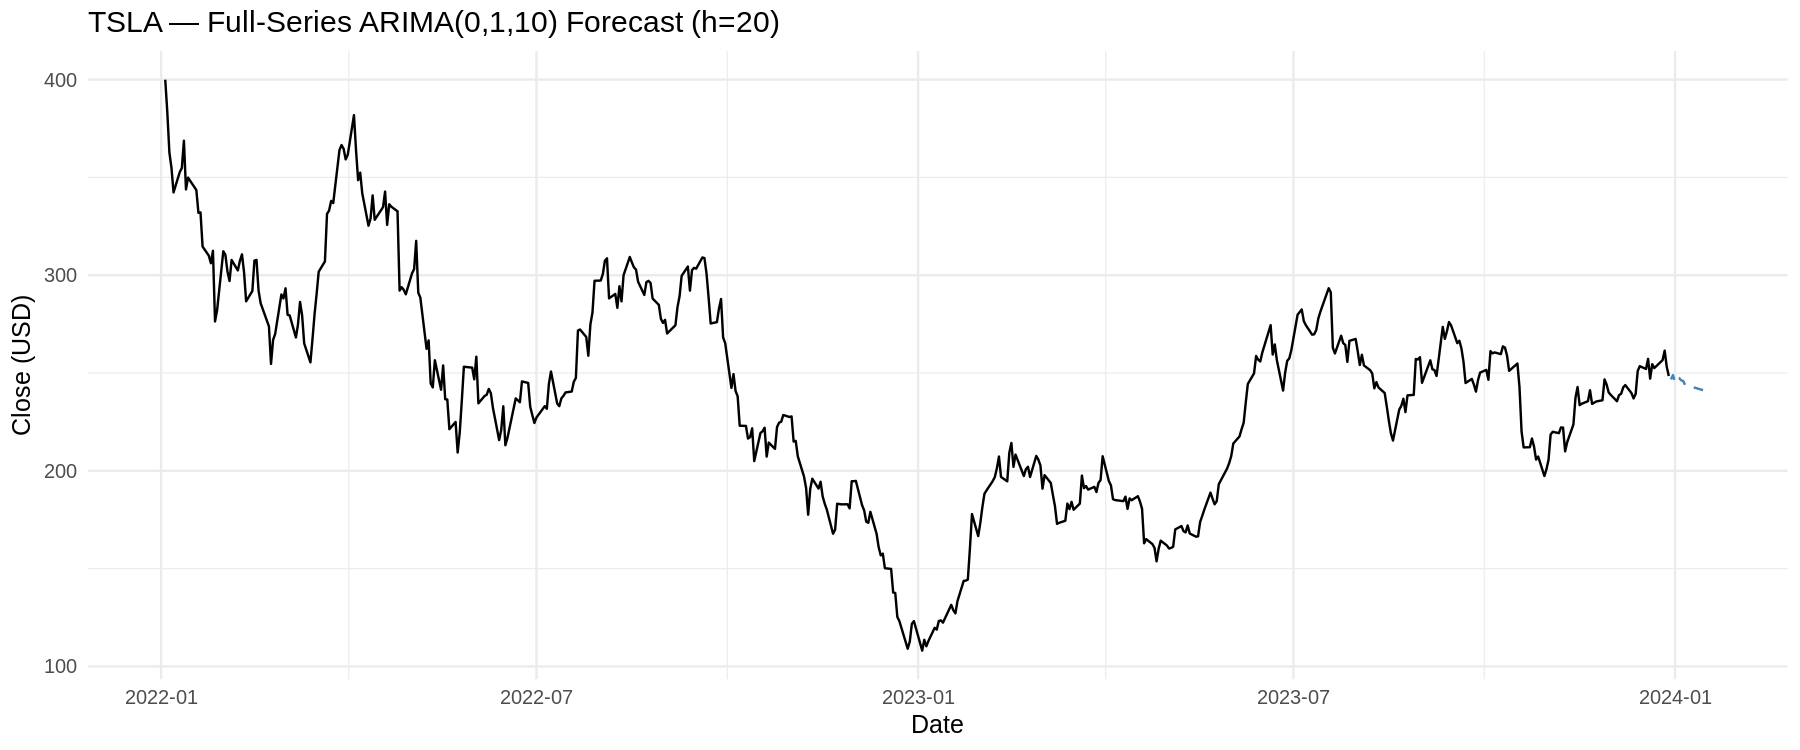

In [5]:
h <- 20  # 예측 지평
fit_full <- fit_ma_safe(y, q = q, d = d)
fc_full  <- forecast::forecast(fit_full, h = h)

future_dates <- seq(from = tail(dates, 1) + 1, by = 1, length.out = h)

ggplot() +
  geom_line(data = df, aes(Date, Close), color = 'black') +
  geom_line(aes(x = future_dates, y = as.numeric(fc_full$mean)), color = 'steelblue', linetype = 'dashed') +
  labs(title = sprintf('%s — Full-Series ARIMA(0,1,%d) Forecast (h=%d)', symbol, q, h),
       x = 'Date', y = 'Close (USD)')

## 4) Fixed-origin(정적 파라미터) — ARIMA(0,1,q), 테스트 전 구간 **동적 예측**

[A: ARIMA static] RMSE=21.6726 | MAE=18.9978 | R2=-0.5471


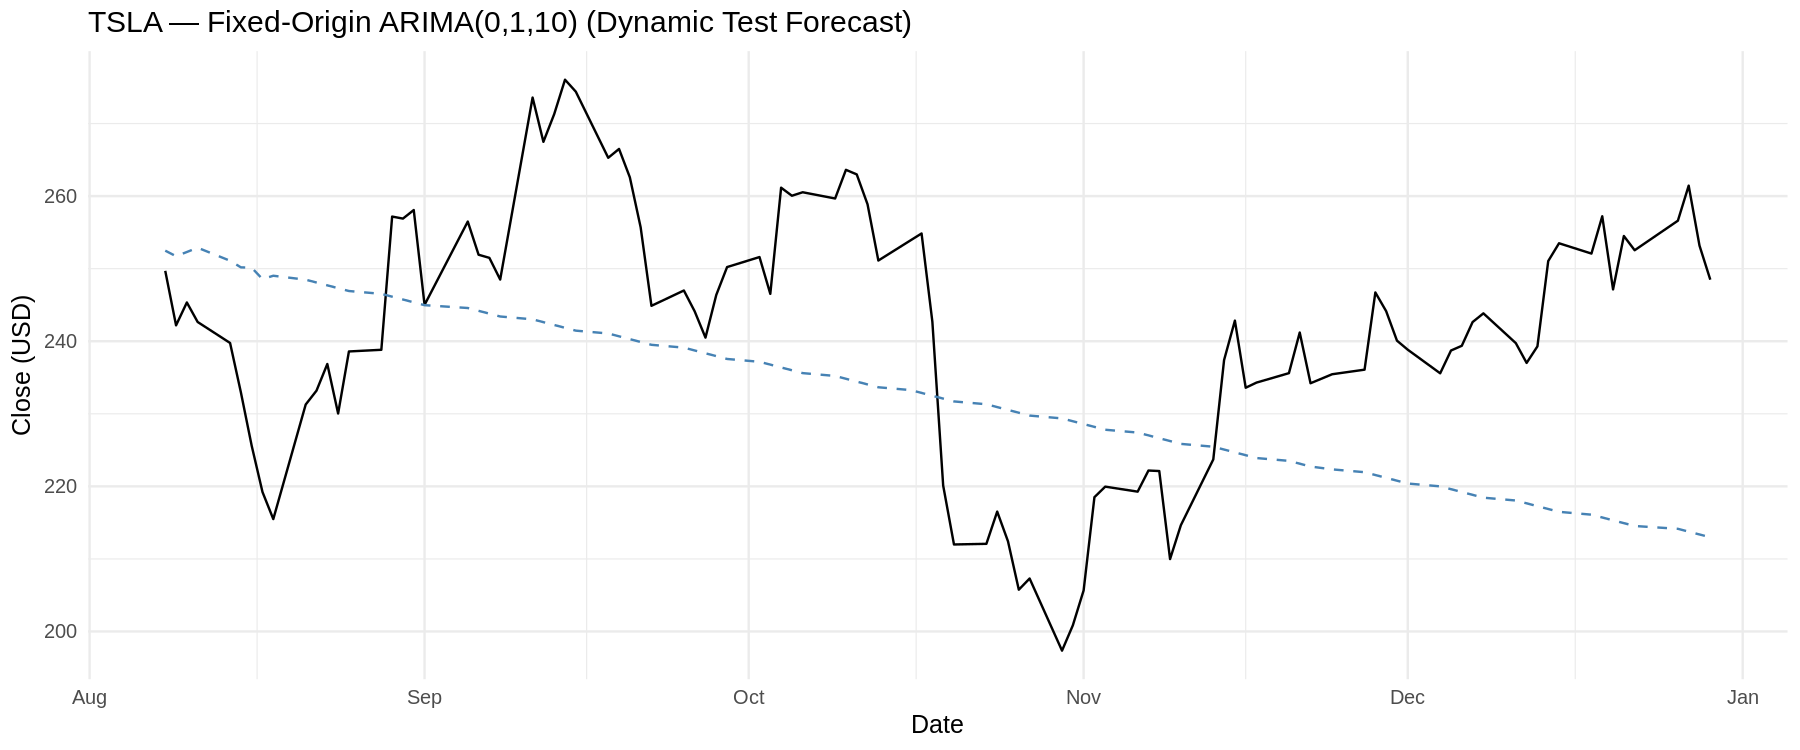

In [6]:
fit_static <- fit_ma_safe(y_train, q = q, d = d)
pred_static <- as.numeric(forecast::forecast(fit_static, h = length(y_test))$mean)

rmse_a <- rmse(y_test, pred_static)
mae_a  <- mae(y_test, pred_static)
r2_a   <- r2(y_test, pred_static)
cat(sprintf('[A: ARIMA static] RMSE=%.4f | MAE=%.4f | R2=%.4f\n', rmse_a, mae_a, r2_a))

ggplot(tibble(Date = dates_te, Actual = y_test, Pred = pred_static), aes(Date)) +
  geom_line(aes(y = Actual), color = 'black') +
  geom_line(aes(y = Pred), color = 'steelblue', linetype = 'dashed') +
  labs(title = sprintf('%s — Fixed-Origin ARIMA(0,1,%d) (Dynamic Test Forecast)', symbol, q),
       x = 'Date', y = 'Close (USD)')

## 5) SMA Dynamic — 테스트에서 **실제값 미사용**, 예측만 이어붙임

[B: SMA dynamic] RMSE=23.8308 | MAE=18.6557 | R2=-0.8705


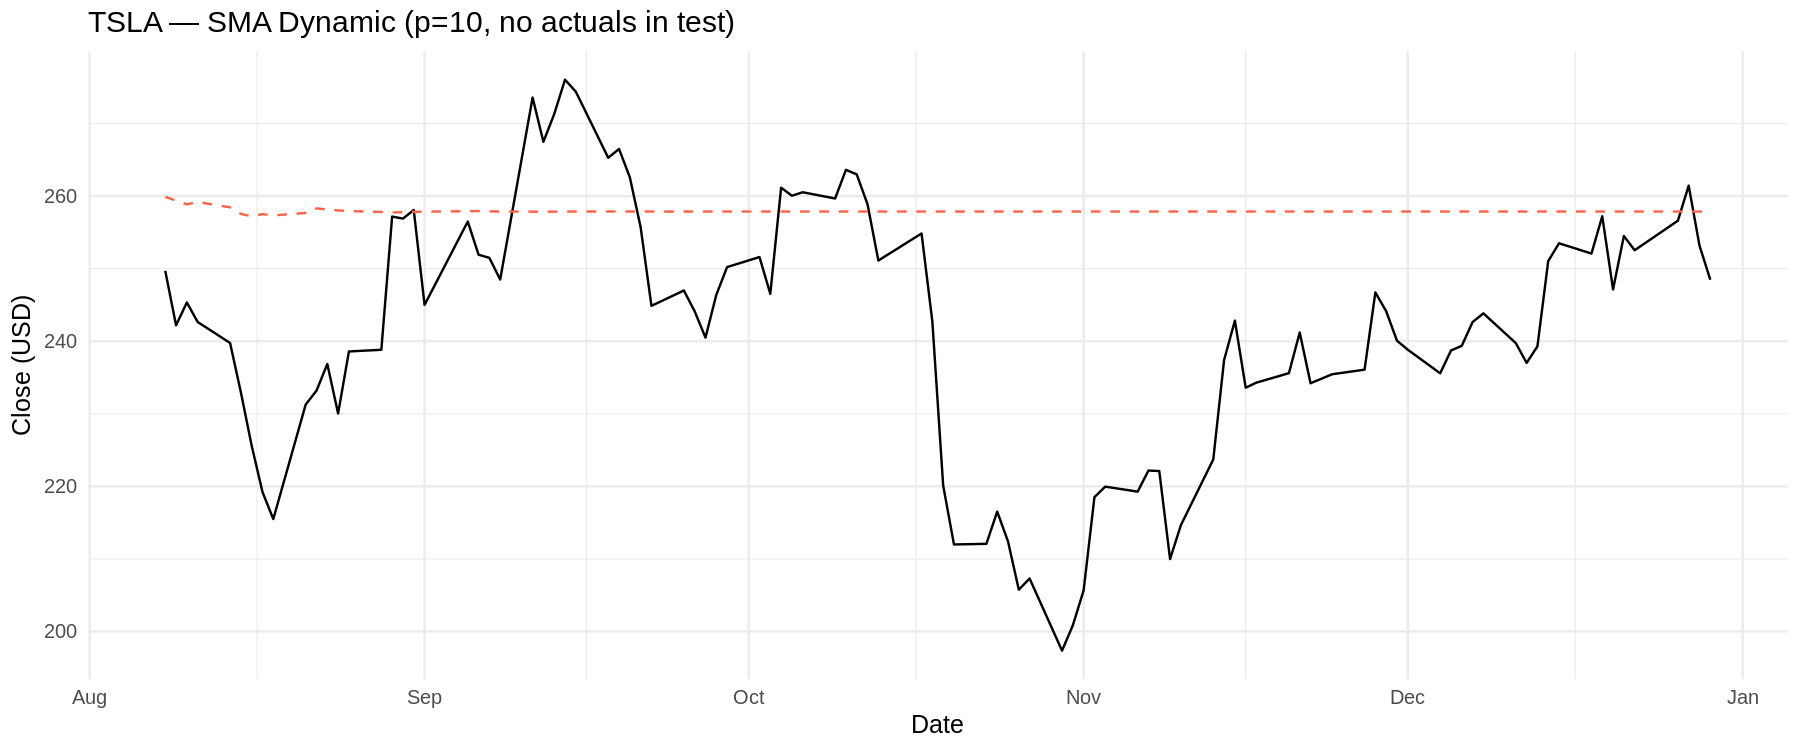

In [7]:
stopifnot(length(y_train) >= p)
window <- y_train[(length(y_train)-p+1):length(y_train)]
pred_sma_dyn <- numeric(length(y_test))

for (i in seq_along(y_test)) {
  yhat <- mean(window)
  pred_sma_dyn[i] <- yhat
  window <- c(tail(window, -1), yhat)  # 실제값 미사용
}

rmse_b <- rmse(y_test, pred_sma_dyn)
mae_b  <- mae(y_test, pred_sma_dyn)
r2_b   <- r2(y_test, pred_sma_dyn)
cat(sprintf('[B: SMA dynamic] RMSE=%.4f | MAE=%.4f | R2=%.4f\n', rmse_b, mae_b, r2_b))

ggplot(tibble(Date = dates_te, Actual = y_test, Pred = pred_sma_dyn), aes(Date)) +
  geom_line(aes(y = Actual), color = 'black') +
  geom_line(aes(y = Pred), color = 'tomato', linetype = 'dashed') +
  labs(title = sprintf('%s — SMA Dynamic (p=%d, no actuals in test)', symbol, p),
       x = 'Date', y = 'Close (USD)')

## 6) SMA 1-step Rolling — 매 시점 직전 **p개 실제값**으로 예측

[C: SMA 1-step rolling] RMSE=14.3438 | MAE=11.3103 | R2=0.3223


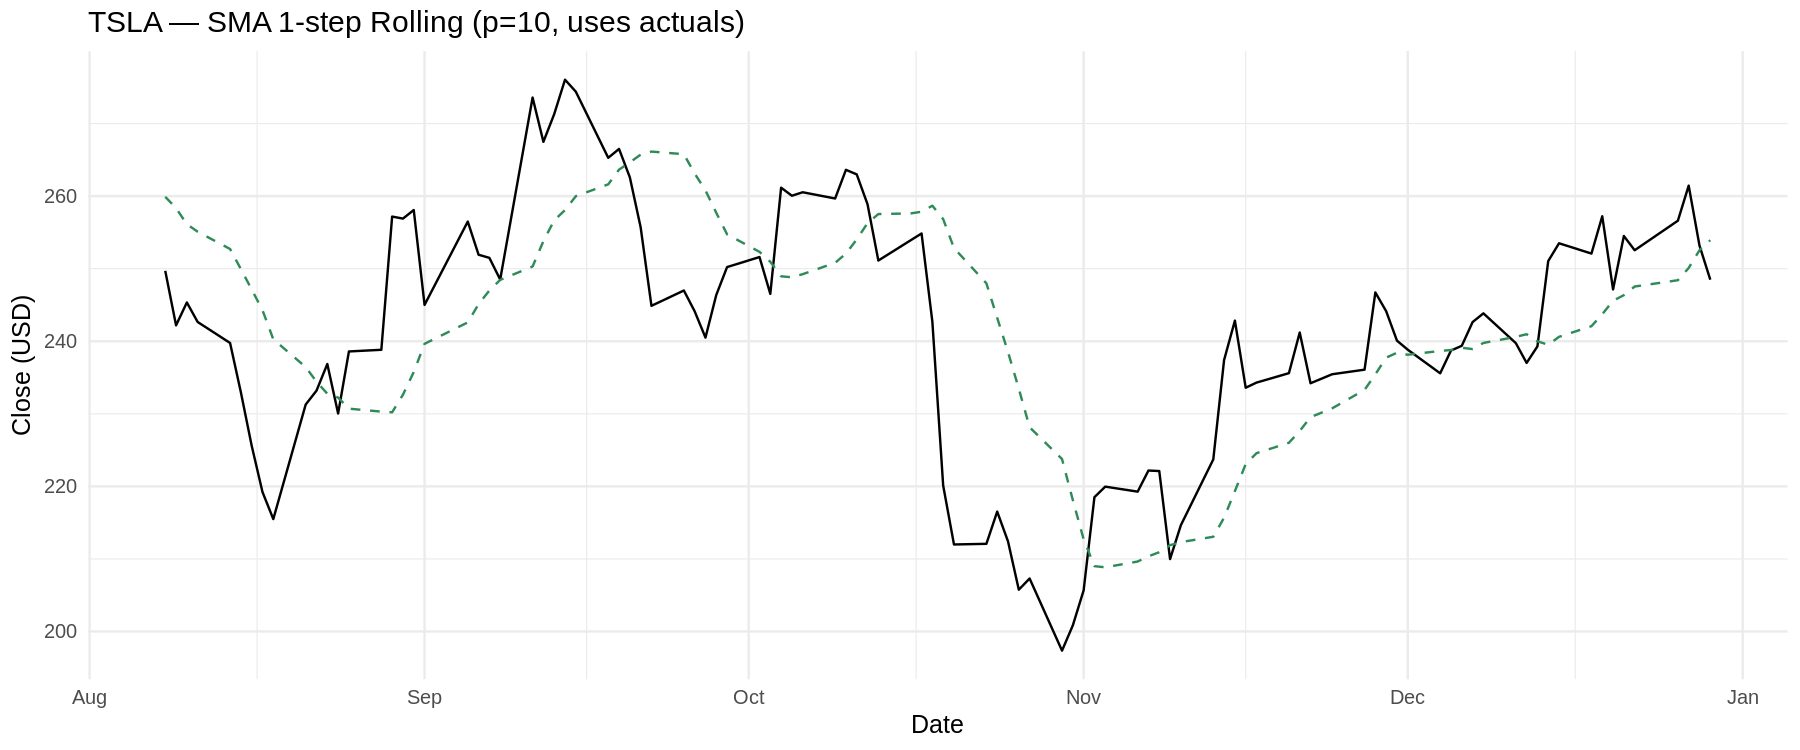

In [8]:
stopifnot(length(y_train) >= p)
window <- y_train[(length(y_train)-p+1):length(y_train)]
pred_sma_roll <- rep(NA_real_, length(y_test))

for (i in seq_along(y_test)) {
  pred_sma_roll[i] <- mean(window)         # 1-step 예측
  window <- c(tail(window, -1), y_test[i]) # 실제값으로 창 갱신
}

rmse_c <- rmse(y_test, pred_sma_roll)
mae_c  <- mae(y_test, pred_sma_roll)
r2_c   <- r2(y_test, pred_sma_roll)
cat(sprintf('[C: SMA 1-step rolling] RMSE=%.4f | MAE=%.4f | R2=%.4f\n', rmse_c, mae_c, r2_c))

ggplot(tibble(Date = dates_te, Actual = y_test, Pred = pred_sma_roll), aes(Date)) +
  geom_line(aes(y = Actual), color = 'black') +
  geom_line(aes(y = Pred), color = 'seagreen', linetype = 'dashed') +
  labs(title = sprintf('%s — SMA 1-step Rolling (p=%d, uses actuals)', symbol, p),
       x = 'Date', y = 'Close (USD)')

## 7) 오버레이 & 요약 표

# A tibble: 3 × 4
  Method                             RMSE   MAE     R2
  <chr>                             <dbl> <dbl>  <dbl>
1 C) SMA(p=10) 1-step rolling        14.3  11.3  0.322
2 A) ARIMA(0,1,10) static (dynamic)  21.7  19.0 -0.547
3 B) SMA(p=10) dynamic (no actuals)  23.8  18.7 -0.871


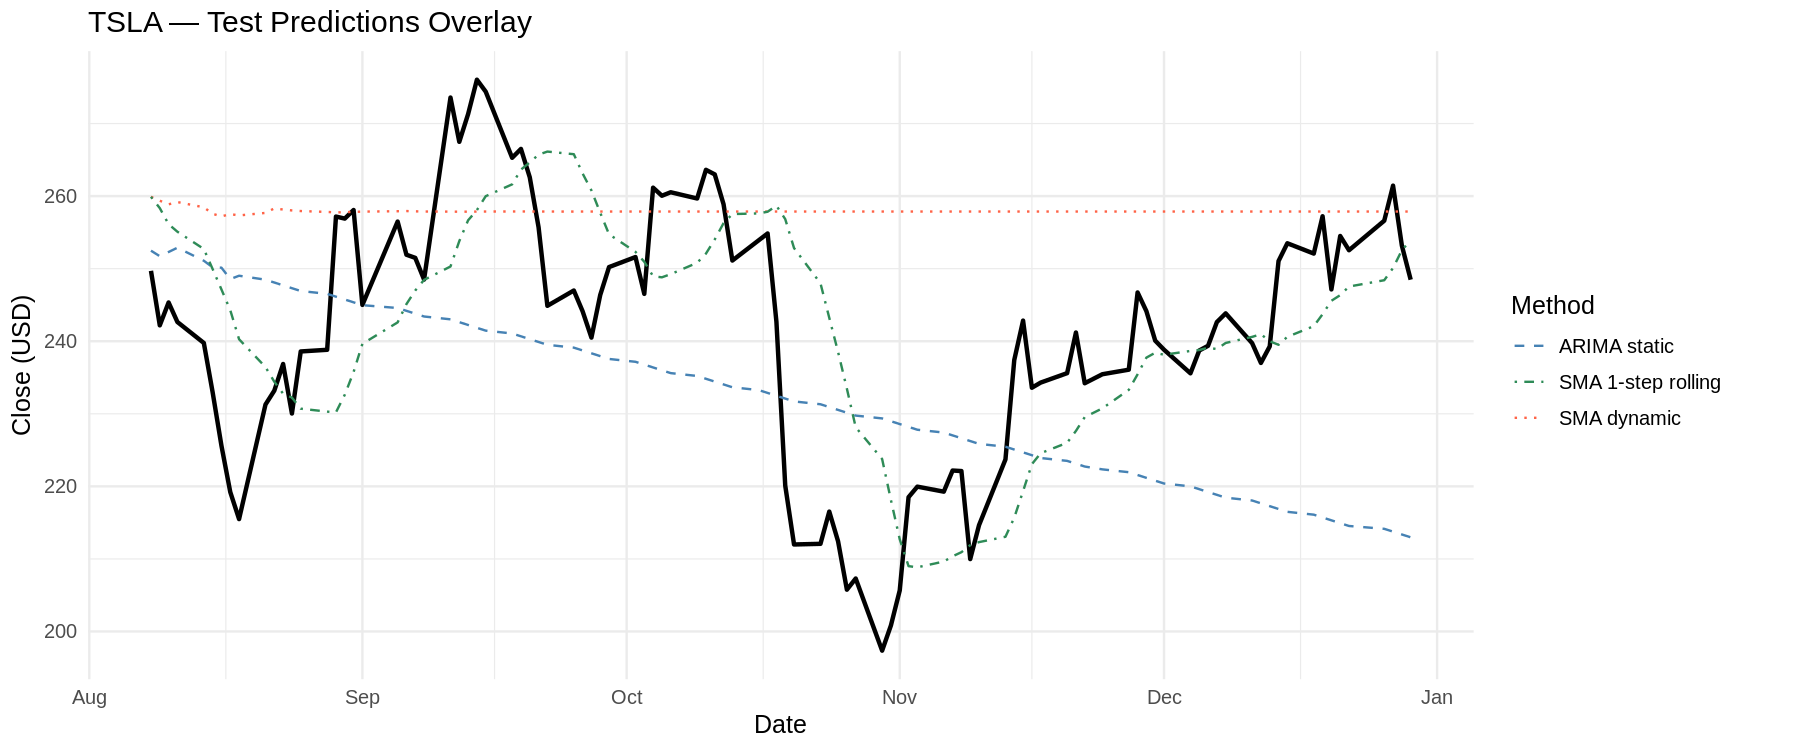

In [9]:
summary <- tibble::tibble(
  Method = c(
    sprintf('A) ARIMA(0,1,%d) static (dynamic)', q),
    sprintf('B) SMA(p=%d) dynamic (no actuals)', p),
    sprintf('C) SMA(p=%d) 1-step rolling', p)
  ),
  RMSE = c(rmse_a, rmse_b, rmse_c),
  MAE  = c(mae_a,  mae_b,  mae_c),
  R2   = c(r2_a,   r2_b,   r2_c)
)
print(summary %>% arrange(RMSE))

ggplot() +
  geom_line(data = tibble(Date = dates_te, y = y_test), aes(Date, y), color = 'black', linewidth = 1) +
  geom_line(data = tibble(Date = dates_te, y = pred_static), aes(Date, y, color = 'ARIMA static'), linetype = 'dashed') +
  geom_line(data = tibble(Date = dates_te, y = pred_sma_dyn), aes(Date, y, color = 'SMA dynamic'), linetype = 'dotted') +
  geom_line(data = tibble(Date = dates_te, y = pred_sma_roll), aes(Date, y, color = 'SMA 1-step rolling'), linetype = 'dotdash') +
  scale_color_manual(values = c('ARIMA static' = 'steelblue', 'SMA dynamic' = 'tomato', 'SMA 1-step rolling' = 'seagreen')) +
  labs(title = sprintf('%s — Test Predictions Overlay', symbol), x = 'Date', y = 'Close (USD)', color = 'Method')

### 비고
- **ARIMA static**은 테스트에서 실제값을 쓰지 않는 **동적 예측**이므로 더 엄격한 OOS입니다.
- **SMA dynamic**은 테스트 구간에서 예측만 이어붙이므로 멀티-스텝에서 평탄화 경향이 있습니다.
- **SMA 1-step rolling**은 매 시점 실제값을 사용하므로 보통 지표가 더 낙관적으로 나옵니다.
- `q, p, d, h`를 적절히 조정해 비교해 보세요.